#### rolling 가능한지 알아보기 + pivot

In [40]:
import pandas as pd
import numpy as np

base='data/train_test/'
m=0
data = pd.read_csv(base+'normalized/'+'normalized_return_'+str(m)+'.csv',index_col = 0)
# date_list = list(data.Date.unique())
# sub_date_list = date_list[0 : 751]
# data=data[data.Date.isin(sub_date_list)]
# TX=data[['BondCode','Date','Normalized_Price_Return']]
# G=TX.groupby('BondCode').count()
# G=G[G.Date>=121]
# TX=TX[TX.BondCode.isin(G.index)]

# pdf1=pd.pivot_table(TX,columns=['BondCode','Date'],values='Normalized_Price_Return')

## full data info

In [ ]:
import pandas as pd
from scipy.stats.mstats import winsorize
df = pd.read_csv('data/Bond_return_file0712.csv',index_col=0,low_memory=False)

In [46]:
df.rename(columns = {'종목코드':'BondCode','기준일자':'Date',
                     '만기수익률':'YieldToMaturity','적용신용등급':'Credit_rate',
                     '채권거래량(거래정보)':'Volume'},inplace=True)

In [58]:
df=df[['BondCode','Date','Return', 'YieldToMaturity' ,'Coupon','Credit_rate','Volume']]

In [ ]:
df['Return']=winsorize(df['Return'],limits=[0.01,0.01]) 
df['YieldToMaturity']=winsorize(df['YieldToMaturity'],limits=[0.01,0.01]) 
df['Coupon']=winsorize(df['Coupon'],limits=[0.01,0.01]) 
df['Volume']=winsorize(df['Volume'],limits=[0.01,0.01]) 

In [ ]:
credits_dic={'AAA': 21, 'AA+': 20, 'AA0':19,
              'AA-': 18, 'A+': 17,'A0':16,
              'A-': 15,'BBB+': 14, 'BBB0':13,
              'BBB-':12,'BB+':11,'BB0':10,'BB-':9,
              'B+':8,'B0':7,'B-':6, 'CCC+':5,
              'CCC':4,'CCC-':3,'CC':2,'C':1,'D':0}

df.loc[:,'Credit_rate_num']=[credits_dic[i] for i in df.Credit_rate]

수익률  통계

In [ ]:
from scipy.stats import skew, kurtosis

d=df.describe()
d.loc['count',:]=round(d.loc['count',:],1)

d=d[['count','mean','std']]
A=pd.DataFrame(index=d.index,columns=['Skewness','Kurtosis'])
for i in d.index:
    aa=d['Return'].astype('float32')
    ske=skew(aa)
    ku=kurtosis(aa, fisher=True)
    A.loc[i,'Skewness']=ske
    A.loc[i,'Kurtosis']=ku
    
with open('data/statistics/statistics.csv','w') as f:
    d.to_csv(f)

신용등급관련 수익률 통계값

In [74]:
def get_statistics_groupby(df):
    count_mean_std=df.groupby('Credit_rate').describe()['Return']
    count_mean_std=count_mean_std[['count','mean','std']]

    A=pd.DataFrame(index=count_mean_std.index,columns=['Skewness','Kurtosis'])
    for i in count_mean_std.index:
        aa=df.loc[df.Credit_rate== i]['Return'].astype('float32')
        ske=skew(aa)
        ku=kurtosis(aa, fisher=True)
        A.loc[i,'Skewness']=ske
        A.loc[i,'Kurtosis']=ku
        
    pd.options.display.float_format = '{:.3f}'.format
    print(pd.concat([count_mean_std,A],axis=1))
    
    with open('data/statistics/creditrate_statistics.csv','w') as f:
        pd.concat([count_mean_std,A],axis=1).to_csv(f)

In [75]:
get_statistics_groupby(df)

             count  mean   std Skewness Kurtosis
적용신용등급                                          
A+      455428.000 0.000 0.001   -4.268   27.939
A-      289580.000 0.000 0.001   -5.203   35.652
A0      395763.000 0.000 0.001   -4.370   28.449
AA+     597053.000 0.000 0.001   -2.780   15.929
AA-     584092.000 0.000 0.001   -3.444   21.382
AA0     578905.000 0.000 0.001   -2.623   14.824
AAA    1034814.000 0.000 0.002   -1.678    7.027
B+        2185.000 0.000 0.001   -4.902   23.723
B-        1506.000 0.000 0.001   -4.690   22.673
B0         693.000 0.000 0.002   -4.588   20.332
BB+       5164.000 0.000 0.001   -5.178   28.120
BB-       2297.000 0.000 0.001   -3.806   19.706
BB0       4743.000 0.000 0.001   -3.234   17.061
BBB+    158808.000 0.000 0.001   -5.792   40.971
BBB-     13472.000 0.000 0.001   -6.088   39.828
BBB0     77495.000 0.000 0.001   -6.401   46.691
C         1295.000 0.001 0.001   -6.473   45.292
CC         702.000 0.000 0.001   -6.408   40.011
CCC       6248.000 0

## predict reuslt

In [1]:
import pandas as pd

def get_predicts(model):
    D=[]
    for i in range(5):
        df=pd.read_csv('data/result/'+model+'_n/'+str(i)+'/predict.csv',index_col=0)
        D.append(df)
    return pd.concat(D).sort_values('Date')
    

In [2]:
LR=get_predicts('lr') #885184
RF=get_predicts('rf')

In [3]:
LSTM=get_predicts('lstm')
DNN=get_predicts('dnn')

## figure compare models

In [4]:
from tqdm import tqdm
import pickle

def acc(data,model):
    acc=[]
    date_list = list(data.Date.unique())
    data = data.reset_index(drop = True)
    K=[28, 140,280,420, 560]
    for k in tqdm(K):
        accuracy_list = []
        for date in date_list:
            data_date = data[data.Date == date]
            data_date = data_date.reset_index(drop = True)
            accu_item = data_date[data_date['y_pred'] == data_date['y_true']].count()[0]
            accuracy_date = accu_item/(2*k)
            accuracy_list.append(accuracy_date)
        accuracy = round(sum(accuracy_list)/len(accuracy_list),4)
        acc.append(accuracy)

    filePath = 'data/result/acc/'+str(model)+'_acc.txt'
    with open(filePath, 'wb') as lf:
        pickle.dump(acc, lf)
    return acc

In [5]:
acc(RF,'rf')
acc(LR,'lr')

100%|██████████| 5/5 [02:45<00:00, 33.10s/it]


[12.6893, 2.5379, 1.2689, 0.846, 0.6345]

In [6]:
acc(LSTM,'lstm')
acc(DNN,'dnn')

100%|██████████| 5/5 [02:50<00:00, 34.13s/it]


[13.3398, 2.668, 1.334, 0.8893, 0.667]

In [7]:
import statistics
import numpy as np

def forfigure(data, model):
  date_list = list(data.Date.unique())
  try:
    data = data.sort_values(['Date','y_prob'],ascending = True)
  except:
    data = data.sort_values(['Date','prob'],ascending = True)
  neutral_profit_nocost = {}
  returnvalue=[]
  stdvalue=[]
  num_list=[28, 140,280, 420,560]
  #num_list=[4, 20, 40, 60, 80]

  for n in num_list:
    for date in tqdm(date_list):
      data_date = data[data.Date == date]
      data = data.sort_values(['y_pred']) #0 1
      long_df = data_date.iloc[n*(-1):]
      short_df = data_date.iloc[:n]
      
      long_daily_profit = long_df['return'].mean()
      short_daily_profit = (-1)*(short_df['return'].mean())
      daily_profit = (long_daily_profit + short_daily_profit)
      neutral_profit_nocost.update({date:daily_profit})

    neutral_nocost_return = np.mean(list(neutral_profit_nocost.values()))
    neutral_nocost_sd = statistics.stdev(neutral_profit_nocost.values())
    returnvalue.append(neutral_nocost_return)
    stdvalue.append(neutral_nocost_sd)

  filePath = 'data/result/acc/'+str(model)+'_rt.txt'
  with open(filePath, 'wb') as lf:
      pickle.dump(returnvalue, lf)

  filePath = 'data/result/acc/'+str(model)+'_std.txt'
  with open(filePath, 'wb') as lf:
      pickle.dump(stdvalue, lf)
  return returnvalue, stdvalue
  

In [8]:
forfigure(RF,'rf')
forfigure(LR,'lr')

100%|██████████| 625/625 [01:25<00:00,  7.34it/s]


([0.10790236710891683,
  0.0804018125941962,
  0.06349000117489412,
  0.06139395258354371,
  0.040632937754221186],
 [0.6379798550314967,
  0.4840923863842586,
  0.4127526480737513,
  0.37425547908991635,
  0.34155653097789906])

In [29]:
forfigure(LSTM,'lstm')
forfigure(DNN,'dnn')

100%|██████████| 625/625 [01:13<00:00,  8.49it/s]


([0.047092249670142756,
  0.028471761273216403,
  0.02427829508324082,
  0.015749443137625413,
  0.017484709354100358],
 [0.5373527987898166,
  0.5166764729665502,
  0.48129438751319137,
  0.46712021862301284,
  0.4344256556879541])

In [30]:
import pickle

def get_pickle_rt_std(model):
    file_path = 'data/result/acc/'+str(model)+'_std.txt'
    with open(file_path, 'rb') as f:
        stdvalue = pickle.load(f)
    file_path = 'data/result/acc/'+str(model)+'_rt.txt'
    with open(file_path, 'rb') as f:
        rtvalue = pickle.load(f)
    return rtvalue,stdvalue

In [31]:
lr_rtvalue,lr_stdvalue =get_pickle_rt_std('lr')
rf_rtvalue,rf_stdvalue =get_pickle_rt_std('rf')
lstm_rtvalue,lstm_stdvalue =get_pickle_rt_std('lstm')
dnn_rtvalue,dnn_stdvalue =get_pickle_rt_std('dnn')

In [32]:
rtvalue=lstm_rtvalue+rf_rtvalue+dnn_rtvalue+lr_rtvalue
stdvalue=lstm_stdvalue+rf_stdvalue+dnn_stdvalue+lr_stdvalue

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def fig_model_compare(data,ylim0,ylim1):
    #value
    f=pd.DataFrame()
    
    # f['K']=[4,20,40,60,80,
    #         4,20,40,60,80,
    #         4,20,40,60,80,
    #         4,20,40,60,80]
    f['K']=[28, 140,280, 420,560,
            28, 140,280, 420,560,
            28, 140,280,420, 560,
            28, 140,280, 420,560]
    f['data']=data
    f['model']=['LSTM','LSTM','LSTM','LSTM','LSTM',
                'RAF','RAF','RAF','RAF','RAF',
                'DNN','DNN','DNN','DNN','DNN',
                'LOG','LOG','LOG','LOG','LOG']    
    fig, axes = plt.subplots(nrows=1
                         , ncols=5
                         , sharey=True
                         , figsize=(20,3))

    #grp = [4,20,40,60,80]
    grp=[28, 140,280, 420,560]
    plt.ylim(ylim0,ylim1)
    colors = ['dodgerblue', 'lightskyblue', 'dimgrey','antiquewhite']
    for i, ax in enumerate(axes):
        df_i = f[f['K'] == grp[i]]
        bars=ax.bar(df_i['model'], df_i['data'], color=colors, edgecolor = 'black', linewidth = 2.5)
        ax.bar_label(bars)
        ax.set_title("K= {grp}".format(grp=grp[i]), fontsize=18)
        if i == 0:
            ax.set_ylabel("Return [%]", fontsize=14)   
    plt.tight_layout()

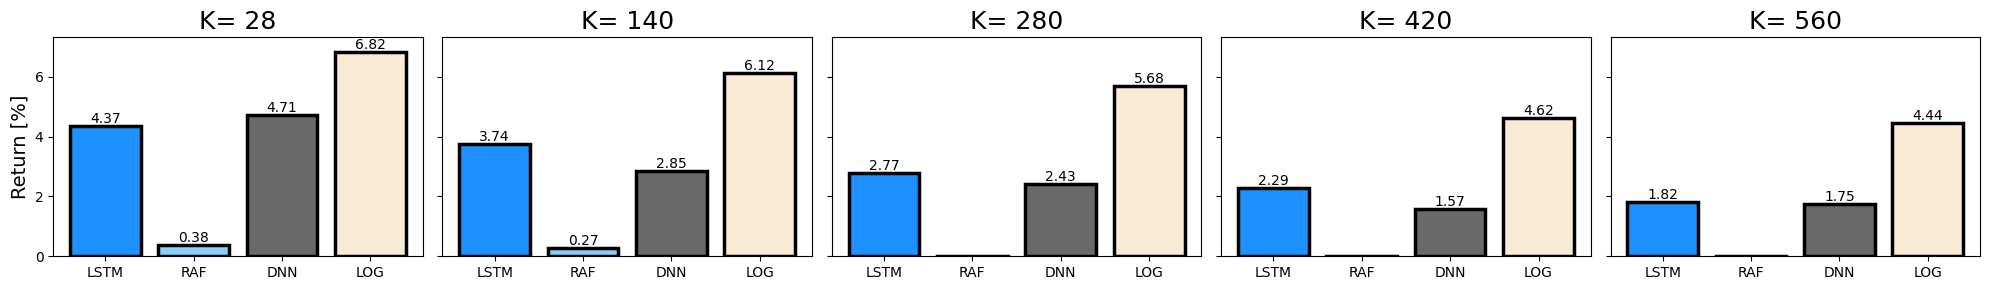

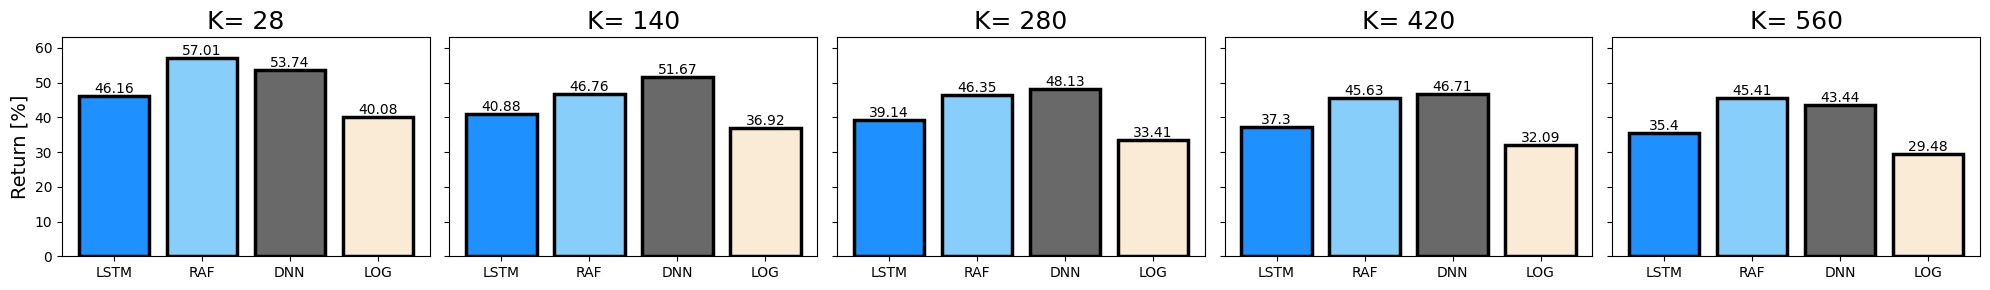

In [36]:
A=pd.DataFrame()
A['rt']=rtvalue
A['rt']=A['rt']*100
A['rt']=round(A['rt'],2)
fig_model_compare(A['rt'],0,max(A['rt'])+0.5)

A['st']=stdvalue
A['st']=A['st']*100
A['st']=round(A['st'],2)
fig_model_compare(A['st'],0,max(A['st'])+6.0)

In [37]:
def get_acc(model):
    filePath = 'data/result/acc/'+str(model)+'_acc.txt'
    with open(filePath, 'rb') as lf:
        acc = pickle.load(lf)
    return acc

In [38]:
lstmacc=get_acc('lstm')
dnnacc=get_acc('dnn')
lracc=get_acc('lr')
rfacc=get_acc('rf')

acc=lstmacc+rfacc+dnnacc+lracc

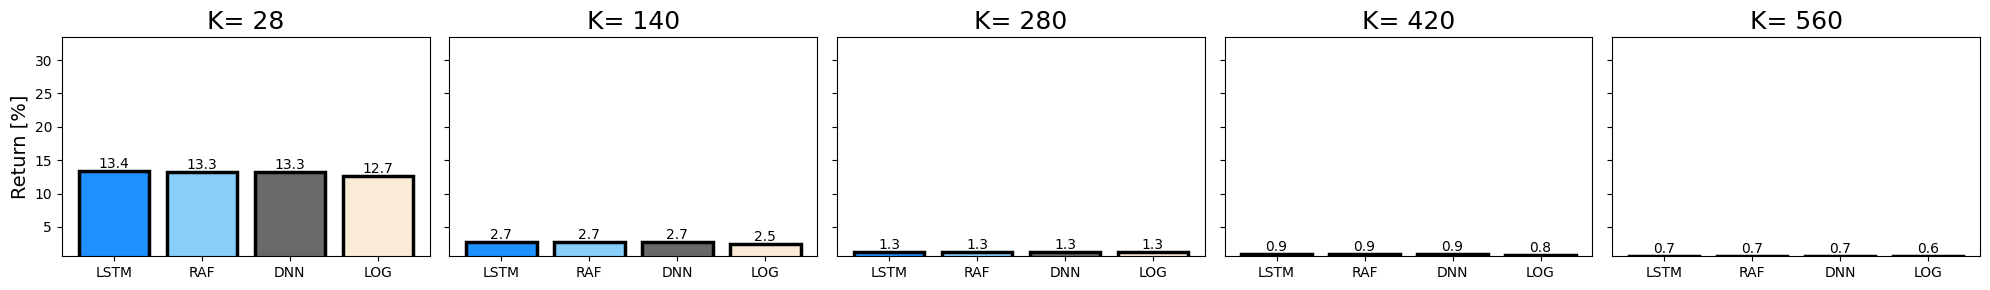

In [39]:
A['acc']=acc
#A['acc']=A['acc']*100
A['acc']=round(A['acc'],1)
fig_model_compare(A['acc'],min(A['acc']),max(A['acc'])+2)

# DM test & PT Test

In [ ]:
#git clone https://github.com/jeslago/epftoolbox.git
#cd epftoolbox
#pip install .

In [85]:
from epftoolbox.evaluation import DM
import numpy as np

basepath='data/result/'
def get_DMtest(data,model):
  date_list = list(data.Date.unique())
  data = data.reset_index(drop = True)
  
  k4 = []
  pt=[]
  pt_ori = []
  
  y_pred=data.columns.tolist().index('y_pred')
  y_true=data.columns.tolist().index('y_true')
  
  for date in date_list:
    data_date = data[data.Date == date]
    data_date = data_date.reset_index(drop = True)
    if len(data_date.bondcode.unique()) >= 80:
      for i in range(4):
        pt_ori.append(data_date.iloc[i,y_true])
        pt.append(data_date.iloc[i,y_pred])
        if data_date.iloc[i,-1] == data_date.iloc[i,-2]:
          k4.append(0)
        else:
          k4.append(1)
      for i in range(4):
        pt_ori.append(data_date.iloc[-(i+1),y_true])
        pt.append(data_date.iloc[-(i+1),y_pred])
        if data_date.iloc[-(i+1),y_true]== data_date.iloc[-(i+1),y_pred]:
          k4.append(0)
        else:
          k4.append(1)
        
  return k4,pt,pt_ori

  

In [87]:
k4_lstm,lstm_pt,lstm_pt_ori=get_DMtest(LSTM,'lstm')
k4_dnn,dnn_pt,dnn_pt_ori=get_DMtest(DNN,'dnn')
k4_lr,lr_pt,lr_pt_ori =get_DMtest(LR,'lr')
k4_rf,rf_pt,rf_pt_ori=get_DMtest(RF,'rf')

In [96]:
def dM(model,mlist,num):
    m_dm=[]
    s=np.array(model).shape[0]
    S=int(s/8)
    k4_ori=np.zeros(s).astype(int).tolist()
    cnt=0
    for i in range(4): 
        if cnt == num:
            m_dm.append('-')
        else:
            if i ==0:
                i=i
            else:
                i=i-1    
            m_dm.append('{:.4f}'.format(DM(np.array(k4_ori).reshape(S,8), 
                                        np.array(model).reshape(S,8), 
                                        np.array(mlist[i]).reshape(S,8), 
                                        norm=1, version='multivariate')))
        cnt+=1
    return m_dm
    

In [97]:
lstmdm=dM(k4_lstm,[k4_rf,k4_dnn,k4_lr],0)
rfdm=dM(k4_rf,[k4_lstm,k4_dnn,k4_lr],1)
dnndm=dM(k4_dnn,[k4_rf,k4_lstm,k4_lr],2)
lrdm=dM(k4_lr,[k4_rf,k4_dnn,k4_lstm],3)

In [98]:
import scipy.stats as stats
def pttest(y, yhat):
    """Given NumPy arrays with predictions and with true values, 
    return Directional Accuracy Score, Pesaran-Timmermann statistic and its p-value
    """
    size = y.shape[0]
    pyz = np.sum(np.sign(y) == np.sign(yhat))/size
    py = np.sum(y > 0)/size
    qy = py*(1 - py)/size
    pz = np.sum(yhat > 0)/size
    qz = pz*(1 - pz)/size
    p = py*pz + (1 - py)*(1 - pz)
    v = p*(1 - p)/size
    w = ((2*py - 1)**2) * qz + ((2*pz - 1)**2) * qy + 4*qy*qz
    pt = (pyz - p) / (np.sqrt(v - w))
    pval = 1 - stats.norm.cdf(pt, 0, 1)
    return pyz, pt, pval

In [99]:
dac, pt, pval = pttest(np.array(lstm_pt_ori), np.array(lstm_pt))
lstm_pt_pv='{:.4f}'.format(pval)
dac, pt, pval = pttest(np.array(rf_pt_ori), np.array(rf_pt))
rf_pt_pv='{:.4f}'.format(pval)
dac, pt, pval = pttest(np.array(lr_pt_ori), np.array(lr_pt))
lr_pt_pv='{:.4f}'.format(pval)
dac, pt, pval = pttest(np.array(dnn_pt_ori), np.array(dnn_pt))
dnn_pt_pv='{:.4f}'.format(pval)

In [101]:
dmpt=pd.DataFrame(columns=[['A: DM test','A: DM test','A: DM test','A: DM test','A: DM test','A: DM test','B: PT test','B: PT test'],['i','j = ','LSTM','RAF','DNN','LOG','Method','Result']])
dmpt.loc[:,('A: DM test','i')]=['LSTM','RAF','DNN','LOG']
dmpt.loc[:,('A: DM test','j = ')]=''
dmpt.loc[:,('A: DM test','LSTM')]=lstmdm
dmpt.loc[:,('A: DM test','RAF')]=rfdm
dmpt.loc[:,('A: DM test','DNN')]=dnndm
dmpt.loc[:,('A: DM test','LOG')]=lrdm
dmpt.loc[:,('B: PT test','Method')]=['LSTM','RAF','DNN','LOG']
dmpt.loc[:,('B: PT test','Result')]=[lstm_pt_pv,rf_pt_pv,dnn_pt_pv,lr_pt_pv]
dmpt

A: DM test                                      B: PT test        
           i j =     LSTM     RAF     DNN     LOG     Method  Result
0       LSTM            -  0.5820  0.1756  0.1274       LSTM  0.0000
1        RAF       0.4180       -  0.1756  0.1274        RAF  0.0000
2        DNN       0.7626  0.8244       -  0.4022        DNN  0.0000
3        LOG       0.8210  0.8726  0.5978       -        LOG  0.0065

## financial performance

In [174]:
def rebalance_freq(ds_1,ds_2):
    ds = pd.concat([ds_1,ds_2],axis = 0,ignore_index = True).reset_index(drop = True)
    unique_length = len(ds.value_counts().keys().tolist())
    non_unique = ds.size- unique_length
    rebalance_percentage = (ds_1.size-non_unique)/(ds_1.size)
    return rebalance_percentage


In [171]:
import pandas as pd
import numpy as np
import scipy.stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

class Statistics:
    def __init__(self,series):
        self.series = np.array(series)
        self.n = len(series) 
    def OLSstderr_tvalue(self,df):
        try:
            model = smf.ols(formula = 'Return ~ 1',data = df).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        except:
            model = smf.ols(formula = 'Profit ~ 1',data = df).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        #print(model.summary2())
        return model.bse ,model.tvalues
    def mean(self):
        return np.mean(self.series)
    def std(self):
        return np.std(self.series)
    def percentiles(self,p=[.25,.5,.75]):
        return pd.Series(self.series).describe(percentiles=p)
    def pos_perc(self):
        return sum(self.series>0)/self.n
    def skewness(self):
        return scipy.stats.skew(self.series)
    def kurtosis(self):
        return scipy.stats.kurtosis(self.series)
    def VaR(self,confidence):
        indx = int(confidence*self.n/100)
        return sorted(self.series)[indx-1]
    def CVaR(self,confidence):
        indx = int(confidence*self.n/100)
        return sum(sorted(self.series)[:indx])/indx
    def MDD(self):
        money = np.cumprod(1+self.series)
        maximums = np.maximum.accumulate(money)
        drawdowns = 1 - money/maximums
        return np.max(drawdowns)     
    def report(self):
        print('Mean \t\t',self.mean())
        print(self.percentiles())
        print('Share>0 \t',self.pos_perc())
        print('Standard dev \t',self.std())
        print('Skewness \t',self.skewness())
        print('Kurtosis \t',self.kurtosis())
        print('VaR_1 \t\t',self.VaR(1))
        print('CVaR_1 \t\t',self.CVaR(1))
        print('VaR_5 \t\t',self.VaR(5))
        print('CVaR_5 \t\t',self.CVaR(5))
        print('MDD \t\t',self.MDD())
    def returnall(self,df):
        percentile=pd.DataFrame(self.percentiles()).iloc[3:,:]
        a,b=self.OLSstderr_tvalue(df)
        stdE=pd.DataFrame(a).values.tolist()[0]
        t=pd.DataFrame(b).values.tolist()[0]
        RES=[]
        RES.append(self.mean())
        RES.extend(stdE)
        RES.extend(t)
        RES.extend(percentile.values.flatten().tolist())
        RES.append(self.pos_perc())
        RES.append(self.std())
        RES.append(self.skewness())
        RES.append(self.kurtosis()),
        RES.append(self.VaR(1))
        RES.append(self.CVaR(1))
        RES.append(self.VaR(5))
        RES.append(self.CVaR(5))
        RES.append(self.MDD())
        return RES

In [177]:
from tqdm import tqdm
from scipy import stats
import statsmodels.formula.api as smf
def backtest(data, m):
  try:
    data = data.sort_values(['Date','y_prob'],ascending = True)
  except:
    data = data.sort_values(['Date','prob'],ascending = True)
  
  data = data.reset_index(drop = True)
  date_list = list(data.Date.unique())

  neutral_profit_nocost = {}
  neutral_profit_cost = {}
  long_profit_cost={}
  short_profit_cost={}
  long_profit_nocost={}
  short_profit_nocost={}
  
  n=4
  for date in tqdm(date_list[:-1]):
    data_date = data[data.Date == date]
    long_df = data_date.iloc[n*(-1):]
    short_df = data_date.iloc[:n]
    long_daily_profit = long_df['return'].mean()
    short_daily_profit = (-1)*(short_df['return'].mean())
    daily_profit = (long_daily_profit + short_daily_profit)
    neutral_profit_nocost.update({date:daily_profit})
    long_profit_nocost.update({date:long_daily_profit})
    short_profit_nocost.update({date:short_daily_profit})

    date_index = date_list.index(date)
    long_part_next = data[data.Date == date_list[date_index+1]].iloc[-4:]
    short_part_next = data[data.Date == date_list[date_index+1]].iloc[:4]
    
    ds_1 = long_df['bondcode']
    ds_2 = long_part_next['bondcode']
    ds_3 = short_df['bondcode']
    ds_4 = short_part_next['bondcode']

    daily_profit_cost = daily_profit - 0.0005*((rebalance_freq(ds_1,ds_2)+rebalance_freq(ds_3,ds_4))/2)
    neutral_profit_cost.update({date:daily_profit_cost})
    long_daily_profit_cost =long_daily_profit - 0.0005*(rebalance_freq(ds_1,ds_2)/2)
    short_daily_profit_cost = short_daily_profit - 0.0005*(rebalance_freq(ds_3,ds_4)/2)
    long_profit_cost.update({date:long_daily_profit_cost})
    short_profit_cost.update({date:short_daily_profit_cost})


  dt=pd.DataFrame(neutral_profit_nocost, index=[0]).T
  dt.rename(columns={0:'Profit'}, inplace=True)
  dt_t=pd.DataFrame(neutral_profit_cost, index=[0]).T
  dt_t.rename(columns={0:'Profit'}, inplace=True)
  print("model",m)
  print('long mean : ',np.mean(list(long_profit_nocost.values())))
  print('short mean : ',np.mean(list(short_profit_nocost.values())))
  #st_log=Statistics(list(neutral_profit_nocost.values()))
  #st_log.report()
  #model = smf.ols(formula = 'Profit ~ 1',data = dt).fit(cov_type='HAC',cov_kwds={'maxlags':1})
  #print(model.summary2())
  print('After transaction cost-----------------------------------------------------------------')
  print('long mean after transaction cost : ',np.mean(list(long_profit_cost.values())))
  print('short mean after transaction cost : ',np.mean(list(short_profit_cost.values()))) 
  #st_log_t=Statistics(list(neutral_profit_cost.values()))
  #st_log_t.report()
  #model_t = smf.ols(formula = 'Profit ~ 1',data = dt_t).fit(cov_type='HAC',cov_kwds={'maxlags':1})
  #print(model_t.summary2())
  
  with open('data/result/acc/'+str(m)+"_profit_no_cost.csv",'w')as f:
    dt.to_csv(f)
    
  with open('data/result/acc/'+str(m)+"_profit_cost.csv",'w')as f:
    dt_t.to_csv(f)

In [178]:
backtest(LSTM,'lstm')
backtest(RF,'rf')
backtest(LR,'lr')
backtest(DNN,'dnn')

100%|██████████| 624/624 [02:00<00:00,  5.16it/s]


model lstm
long mean :  0.0022150312445552603
short mean :  0.0907998322865532
After transaction cost-----------------------------------------------------------------
long mean after transaction cost :  0.002012407045837309
short mean after transaction cost :  0.0905742713891173


100%|██████████| 624/624 [02:05<00:00,  4.98it/s]


model rf
long mean :  0.04968753465647437
short mean :  0.09021489910268113
After transaction cost-----------------------------------------------------------------
long mean after transaction cost :  0.04957104827826924
short mean after transaction cost :  0.08996570038473241


100%|██████████| 624/624 [02:03<00:00,  5.06it/s]


model lr
long mean :  -0.2885692963462177
short mean :  -0.0029351691486901666
After transaction cost-----------------------------------------------------------------
long mean after transaction cost :  -0.28873416012826897
short mean after transaction cost :  -0.0031842677063824722


100%|██████████| 624/624 [02:05<00:00,  4.96it/s]

model dnn
long mean :  0.03240832495413375
short mean :  0.1601426056682938
After transaction cost-----------------------------------------------------------------
long mean after transaction cost :  0.03228102126823633
short mean after transaction cost :  0.15994458884137075


In [179]:
lstm_nc_long_short_mean=[0.0022150312445552603,0.0907998322865532]
lstm_c_long_short_mean=[0.002012407045837309, 0.0905742713891173]

rf_nc_long_short_mean=[0.04968753465647437,0.09021489910268113]
rf_c_longs_short_mean=[0.04957104827826924,0.08996570038473241]

lr_nc_long_short_mean=[-0.2885692963462177,-0.0029351691486901666]
lr_c_long_short_mean=[-0.28873416012826897,-0.0031842677063824722]

dnn_nc_long_short_mean=[0.03240832495413375,0.1601426056682938]
dnn_c_long_short_mean=[0.03228102126823633, 0.15994458884137075]

In [122]:
#DNN.groupby('Date').count()['bondcode'].mean()

1416.2944

In [104]:
kospi200=pd.read_csv('data/kospitest.csv')

In [105]:
kospi200.rename(columns={'날짜':'Date','종가':'Price'},inplace=True)
k200=kospi200[['Date','Price']].sort_values('Date')

In [106]:
k200['Return']= k200.Price.pct_change(1).dropna()

In [107]:
k200=k200.reset_index(drop=True).dropna()

In [91]:
#k200=k200.iloc[749:,[0,2]]

In [108]:
k200['Date']=k200['Date'].apply(lambda x: x.replace(" ",''))

In [109]:
k200.set_index('Date',inplace = True)

In [117]:
lstm_pr_cost=pd.read_csv('data/result/acc/lstm_profit_cost.csv')
dnn_pr_cost=pd.read_csv('data/result/acc/dnn_profit_cost.csv')
lr_pr_cost=pd.read_csv('data/result/acc/lr_profit_cost.csv')
rf_pr_cost=pd.read_csv('data/result/acc/rf_profit_cost.csv')

lstm_pr_no_cost=pd.read_csv('data/result/acc/lstm_profit_no_cost.csv')
dnn_pr_no_cost=pd.read_csv('data/result/acc/dnn_profit_no_cost.csv')
lr_pr_no_cost=pd.read_csv('data/result/acc/lr_profit_no_cost.csv')
rf_pr_no_cost=pd.read_csv('data/result/acc/rf_profit_no_cost.csv')

In [120]:
datess=lstm_pr_cost.iloc[:,0]

In [122]:
k200=k200[k200.index.isin(datess)]

In [180]:
lstm_pr_cost_st=Statistics(list(lstm_pr_cost['Profit']))
dnn_pr_cost_st=Statistics(list(dnn_pr_cost['Profit']))
lr_pr_cost_st=Statistics(list(lr_pr_cost['Profit']))
rf_pr_cost_st=Statistics(list(rf_pr_cost['Profit']))

lstm_pr_no_cost_st=Statistics(list(lstm_pr_no_cost['Profit']))
dnn_pr_no_cost_st=Statistics(list(dnn_pr_no_cost['Profit']))
lr_pr_no_cost_st=Statistics(list(lr_pr_no_cost['Profit']))
rf_pr_no_cost_st=Statistics(list(rf_pr_no_cost['Profit']))

k200_st=Statistics(list(k200['Return']))

In [181]:
TM=lstm_pr_cost_st.returnall(lstm_pr_cost)
F=rf_pr_cost_st.returnall(rf_pr_cost)
NN=dnn_pr_cost_st.returnall(dnn_pr_cost)
R=lr_pr_cost_st.returnall(lr_pr_cost)

NTM=lstm_pr_no_cost_st.returnall(lstm_pr_no_cost)
NF=rf_pr_no_cost_st.returnall(rf_pr_no_cost)
NNN=dnn_pr_no_cost_st.returnall(dnn_pr_no_cost)
NR=lr_pr_no_cost_st.returnall(lr_pr_no_cost)

k=k200_st.returnall(k200)


In [184]:
perfo=pd.DataFrame(columns=[['Before transaction costs',
                             'Before transaction costs',
                             'Before transaction costs',
                             'Before transaction costs',
                             'After transaction costs',
                             'After transaction costs',
                             'After transaction costs',
                             'After transaction costs',
                             ''],
                            ['LSTM','RAF','DNN','LOG','LSTM','RAF','DNN','LOG','MKT']], 
                   index=['Mean return (long)',
                          'Mean return (short)',
                          'Mean return',
                          'Standard error',
                          't-statistic',
                          'Minimum',
                          'Quartile 1',
                          'Median',
                          'Quartile 3',
                          'Maximum',
                          'Share>0',
                          'Standard dev.',
                          'Skewness',
                          'Kurtosis',
                          '1-percent VaR',
                          '1-percent CVaR',
                          '5-percent VaR',
                          '5-percent CVaR',
                          'Max. drawdown'])

perfo.loc[:,('Before transaction costs','LSTM')]=np.round(lstm_nc_long_short_mean+NTM,4)
perfo.loc[:,('Before transaction costs','RAF')]=np.round(rf_nc_long_short_mean+NF,4)
perfo.loc[:,('Before transaction costs','DNN')]=np.round(dnn_nc_long_short_mean+NNN,4)
perfo.loc[:,('Before transaction costs','LOG')]=np.round(lr_nc_long_short_mean+NR,4)
perfo.loc[:,('After transaction costs','LSTM')]=np.round(lstm_c_long_short_mean+TM,4)
perfo.loc[:,('After transaction costs','RAF')]=np.round(rf_c_longs_short_mean+F,4)
perfo.loc[:,('After transaction costs','DNN')]=np.round(dnn_c_long_short_mean+NN,4)
perfo.loc[:,('After transaction costs','LOG')]=np.round(lr_c_long_short_mean+R,4)
perfo.loc[:,('','MKT')]=np.round([999999,999999]+k,4)
perfo = perfo.replace(999999, '-')

In [185]:
perfo

Before transaction costs                         \
                                        LSTM         RAF        DNN   
Mean return (long)                    0.0022      0.0497     0.0324   
Mean return (short)                   0.0908      0.0902     0.1601   
Mean return                           0.0930      0.1399     0.1926   
Standard error                        0.0541      0.0324     0.0747   
t-statistic                           1.7207      4.3207     2.5780   
Minimum                             -10.4843     -3.9922    -9.4327   
Quartile 1                           -0.2505     -0.1160    -0.2646   
Median                                0.1057      0.1471     0.1747   
Quartile 3                            0.4989      0.4109     0.8069   
Maximum                               6.1641      3.8133    12.2545   
Share>0                               0.5994      0.6522     0.6795   
Standard dev.                         1.3371      0.8240     1.8164   
Skewness                             -1.8821      0.0177    -0.0750   
Kurtosis                             16.4215      5.3040     9.2823   
1-percent VaR                        -3.9108     -2.6857    -6.3257   
1-percent CVaR                       -7.4972     -3.2157    -7.9519   
5-percent VaR                        -1.8345     -1.1989    -2.7738   
5-percent CVaR                       -3.5878     -1.9614    -4.6343   
Max. drawdown                       566.1222  43559.0466  5705.6841   

                                After transaction costs              \
                            LOG                    LSTM         RAF   
Mean return (long)      -0.2886                  0.0020      0.0496   
Mean return (short)     -0.0029                  0.0906      0.0900   
Mean return             -0.2915                  0.0926      0.1395   
Standard error           0.0820                  0.0541      0.0324   
t-statistic             -3.5565                  1.7128      4.3093   
Minimum                -12.7282                -10.4847     -3.9925   
Quartile 1              -0.7184                 -0.2510     -0.1163   
Median                   0.0639                  0.1053      0.1468   
Quartile 3               0.3150                  0.4985      0.4104   
Maximum                 11.0832                  6.1636      3.8128   
Share>0                  0.5641                  0.5994      0.6522   
Standard dev.            1.9896                  1.3371      0.8240   
Skewness                -0.5371                 -1.8821      0.0176   
Kurtosis                 7.7802                 16.4218      5.3036   
1-percent VaR           -6.7939                 -3.9112     -2.6862   
1-percent CVaR          -8.6392                 -7.4976     -3.2161   
5-percent VaR           -4.0722                 -1.8350     -1.1994   
5-percent CVaR          -5.8490                 -3.5882     -1.9618   
Max. drawdown        17928.8001                562.3487  43044.7491   

                                                    
                           DNN         LOG     MKT  
Mean return (long)      0.0323     -0.2887       -  
Mean return (short)     0.1599     -0.0032       -  
Mean return             0.1922     -0.2919  0.0001  
Standard error          0.0747      0.0820  0.0005  
t-statistic             2.5736     -3.5615  0.1488  
Minimum                -9.4331    -12.7285 -0.0643  
Quartile 1             -0.2650     -0.7189 -0.0058  
Median                  0.1746      0.0637  0.0004  
Quartile 3              0.8065      0.3146  0.0064  
Maximum                12.2540     11.0827  0.0519  
Share>0                 0.6795      0.5641  0.5192  
Standard dev.           1.8164      1.9896  0.0124  
Skewness               -0.0751     -0.5372 -0.3051  
Kurtosis                9.2822      7.7800  4.0115  
1-percent VaR          -6.3259     -6.7944 -0.0369  
1-percent CVaR         -7.9524     -8.6397 -0.0494  
5-percent VaR          -2.7742     -4.0727 -0.0203  
5-percent CVaR         -4.634

In [ ]:
import pandas as pd
import datetime
import numpy as np

dt_t=pd.read_csv('data/result/acc/lstm_profit_cost.csv', index_col=0)
dt_t=dt_t.reset_index()
dt_t.rename(columns={'index':'Date'}, inplace=True)
dt_t['Date']=pd.to_datetime(dt_t['Date'])
dt_t['Year'] = dt_t['Date'].dt.strftime('%Y')
dt_t['Year']=dt_t['Year'].astype(int)
cum0=dt_t[dt_t['Year']<=2013]
cum1=dt_t[dt_t['Year']>2013]
cum0_d =np.exp(np.log1p(cum0['Profit']).cumsum()) - 1 
cum0['cum']=cum0_d
cum1_d =np.exp(np.log1p(cum1['Profit']).cumsum()) - 1 
cum1['cum']=cum1_d

dt_r=pd.read_csv('data/result/acc/rf_profit_cost.csv', index_col=0)
dt_r=dt_r.reset_index()
dt_r.rename(columns={'index':'Date'}, inplace=True)
dt_r['Date']=pd.to_datetime(dt_r['Date'])
dt_r['Year'] = dt_r['Date'].dt.strftime('%Y')
dt_r['Year']=dt_r['Year'].astype(int)
cum0_r=dt_r[dt_r['Year']<=2013]
cum1_r=dt_r[dt_r['Year']>2013]
cum0_d_r =np.exp(np.log1p(cum0_r['Profit']).cumsum()) - 1 
cum0_r['cum']=cum0_d_r
cum1_d_r =np.exp(np.log1p(cum1_r['Profit']).cumsum()) - 1 
cum1_r['cum']=cum1_d_r

## cumulative profit

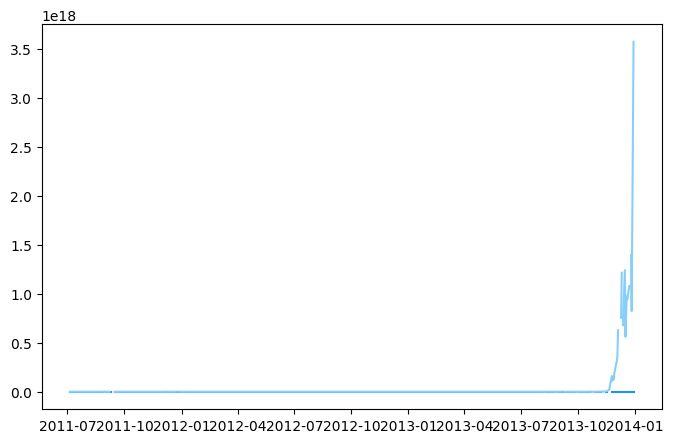

In [187]:
import matplotlib.pyplot as plt
 
fig = plt.figure(figsize=(8,5)) ## 캔버스 생성
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
 
ax.plot(cum0['Date'],cum0['cum'],color='dodgerblue') ## 선그래프 생성
ax.plot(cum0_r['Date'],cum0_r['cum'],color='lightskyblue') ## 선그래프 생성

plt.show()

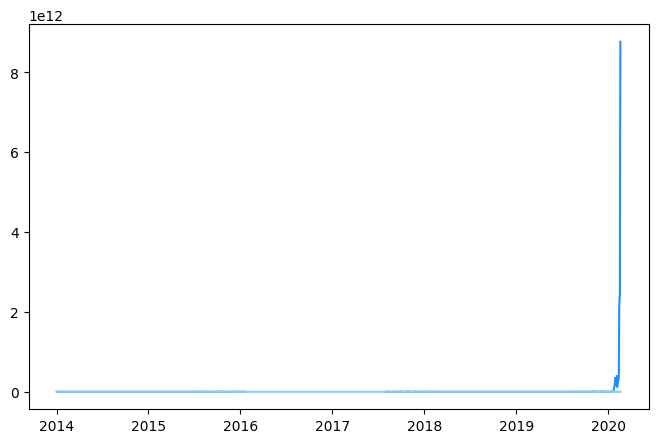

In [188]:
import matplotlib.pyplot as plt
 
fig = plt.figure(figsize=(8,5)) ## 캔버스 생성
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
 
ax.plot(cum1['Date'],cum1['cum'],color='dodgerblue') ## 선그래프 생성
ax.plot(cum1_r['Date'],cum1_r['cum'],color='lightskyblue') ## 선그래프 생성

plt.show()

## average daily returns by year & annualized sharperatio

In [189]:
import pandas as pd
dt_t=pd.read_csv('data/result/acc/lstm_profit_cost.csv', index_col=0)
dt_t=dt_t.reset_index()
dt_t.rename(columns={'index':'Date'}, inplace=True)
dt_t['Date']=pd.to_datetime(dt_t['Date'])
import datetime
dt_t['Year'] = dt_t['Date'].dt.strftime('%Y')
dt_t.set_index('Date',inplace = True)
df=dt_t.groupby(['Year'], as_index=False).mean()
df_std=dt_t.groupby(['Year'], as_index=False).std()
df_sharpe=pd.DataFrame({'Sharpe ratio':df['Profit']/df_std['Profit'], 'Year':df_std['Year']})
import numpy as np
df_split = np.array_split(df, 2)
df_sharpe_split = np.array_split(df_sharpe, 2)

<BarContainer object of 5 artists>

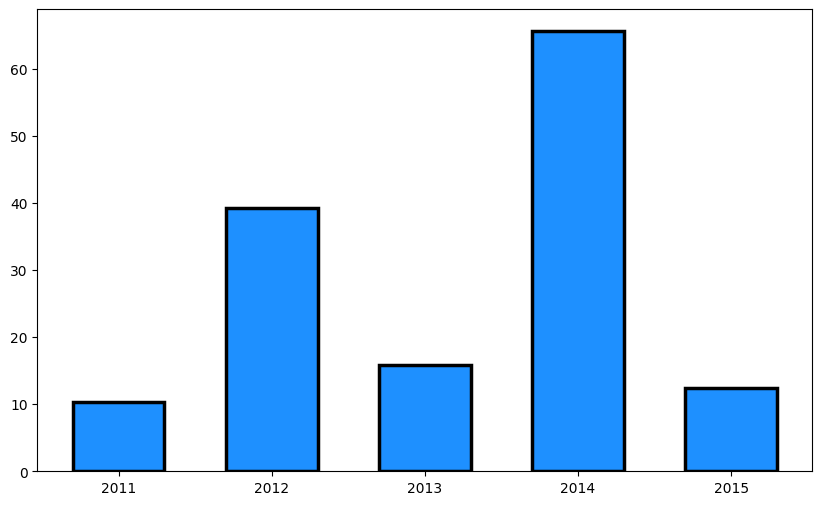

In [190]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))			
plt.bar(df_split[0]['Year'], df_split[0]['Profit']*100, width=0.6, color='dodgerblue', edgecolor = 'black', linewidth = 2.5)

<BarContainer object of 5 artists>

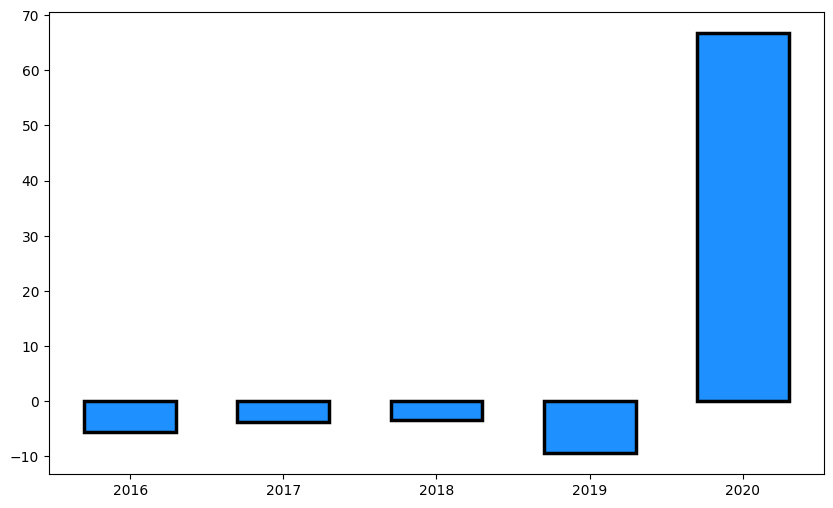

In [191]:
plt.figure(figsize=(10, 6))		
plt.bar(df_split[1]['Year'], df_split[1]['Profit']*100, width=0.6, color='dodgerblue', edgecolor = 'black', linewidth = 2.5)

<BarContainer object of 5 artists>

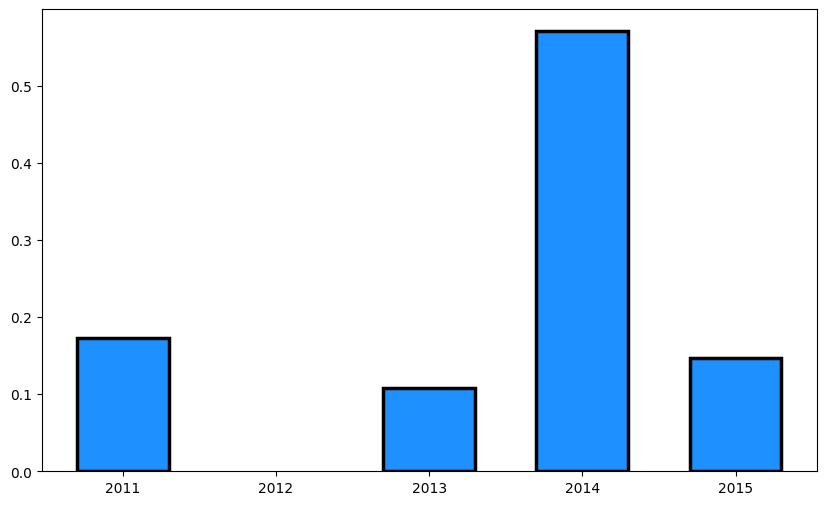

In [192]:
plt.figure(figsize=(10, 6))		
plt.bar(df_sharpe_split[0]['Year'], df_sharpe_split[0]['Sharpe ratio'], width=0.6, color='dodgerblue', edgecolor = 'black', linewidth = 2.5)

<BarContainer object of 5 artists>

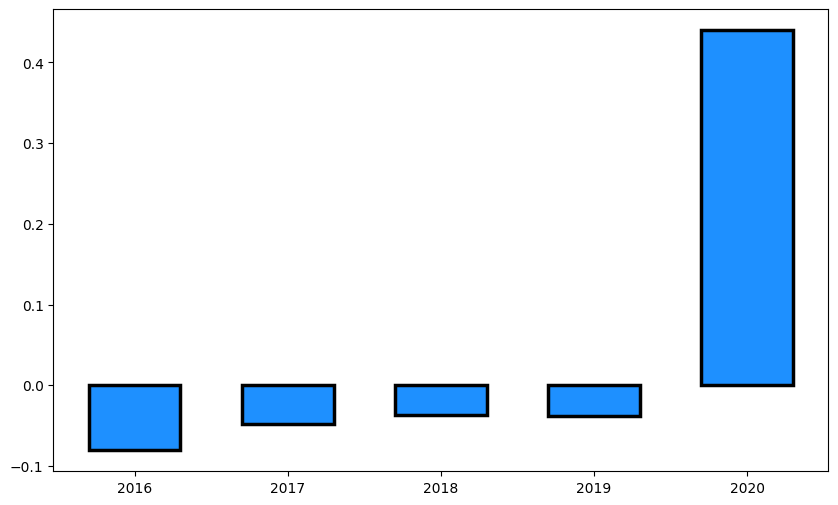

In [193]:
plt.figure(figsize=(10, 6))		
plt.bar(df_sharpe_split[1]['Year'], df_sharpe_split[1]['Sharpe ratio'], width=0.6, color='dodgerblue', edgecolor = 'black', linewidth = 2.5)

In [194]:
import pandas as pd
dt_t=pd.read_csv("data/result/acc/rf_profit_cost.csv", index_col=0)
rf_t=dt_t.reset_index()
rf_t.rename(columns={'index':'Date'}, inplace=True)
rf_t['Date']=pd.to_datetime(rf_t['Date'])
import datetime
rf_t['Year'] = rf_t['Date'].dt.strftime('%Y')
rf_t.set_index('Date',inplace = True)
df_rf=rf_t.groupby(['Year'], as_index=False).mean()
df_rf_std=rf_t.groupby(['Year'], as_index=False).std()
df_rf_sharpe=pd.DataFrame({'Sharpe ratio':df_rf['Profit']/df_rf_std['Profit'], 'Year':df_rf_std['Year']})
import numpy as np
df_rf_split = np.array_split(df_rf, 2)
df_rf_sharpe_split = np.array_split(df_rf_sharpe, 2)

<BarContainer object of 5 artists>

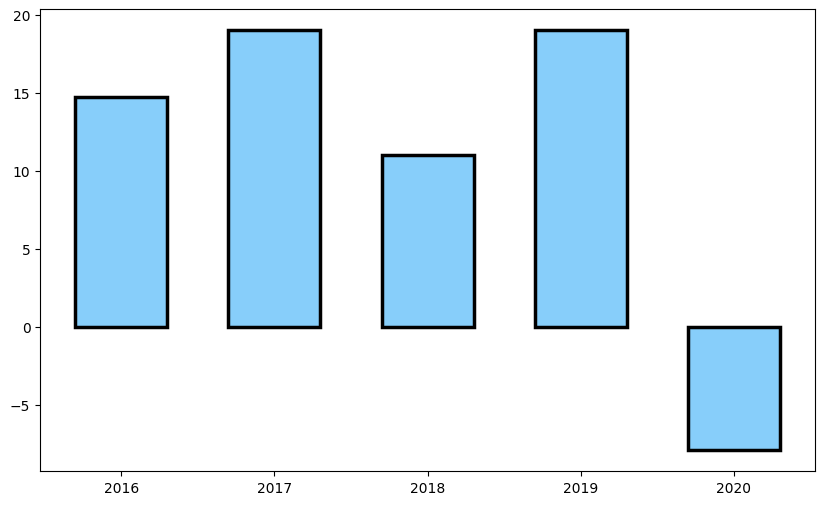

In [195]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))			
plt.bar(df_rf_split[1]['Year'], df_rf_split[1]['Profit']*100, width=0.6, color='lightskyblue', edgecolor = 'black', linewidth = 2.5)



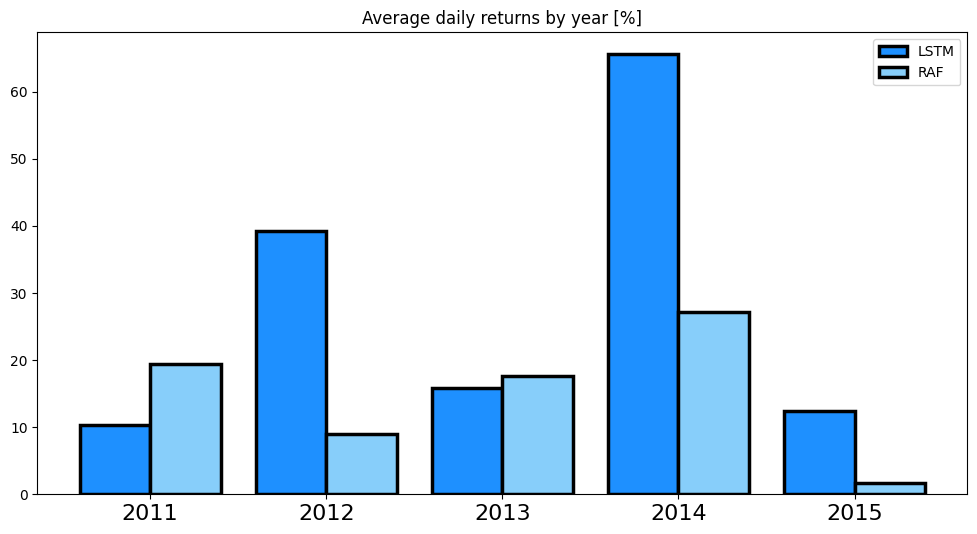

In [201]:
# 그림 사이즈, 바 굵기 조정
fig, ax = plt.subplots(figsize=(12,6))
bar_width = 0.4

index = np.arange(5)
p_lstm_0=plt.bar(index, df_split[0]['Profit']*100, bar_width, color='dodgerblue', edgecolor = 'black', linewidth = 2.5, label='LSTM')
p_rf_0=plt.bar(index+ bar_width, df_rf_split[0]['Profit']*100, bar_width, color='lightskyblue', edgecolor = 'black', linewidth = 2.5, label='RAF')
plt.title('Average daily returns by year [%]')
plt.xticks(np.arange(0.2, 4 + bar_width, 1), df_split[0]['Year'],fontsize=16)
plt.legend()
plt.show()

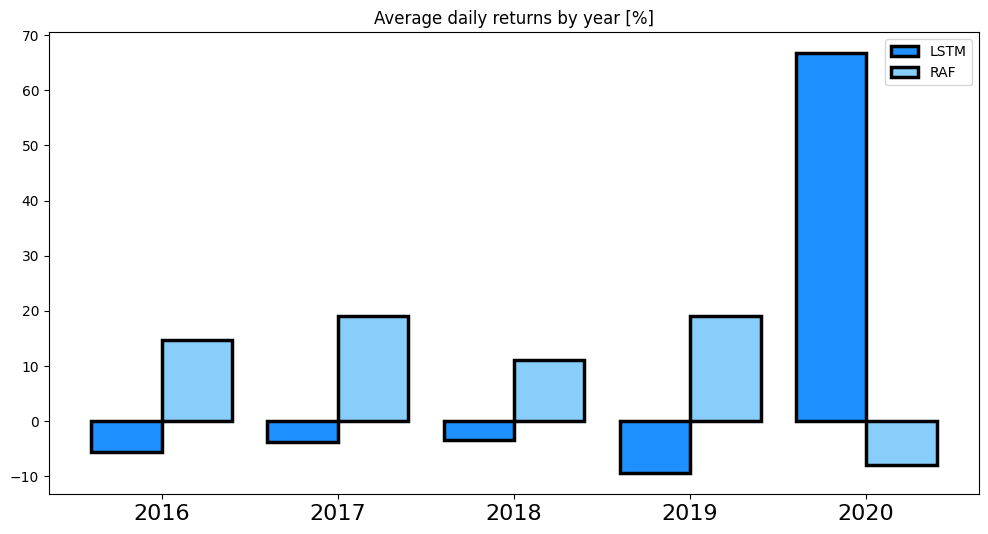

In [202]:
# 그림 사이즈, 바 굵기 조정
fig, ax = plt.subplots(figsize=(12,6))
bar_width = 0.4

index = np.arange(5)
p_lstm_0=plt.bar(index, df_split[1]['Profit']*100, bar_width, color='dodgerblue', edgecolor = 'black', linewidth = 2.5, label='LSTM')
p_rf_0=plt.bar(index+ bar_width, df_rf_split[1]['Profit']*100, bar_width, color='lightskyblue', edgecolor = 'black', linewidth = 2.5, label='RAF')
plt.title('Average daily returns by year [%]')
plt.xticks(np.arange(0.2, 4 + bar_width, 1), df_split[1]['Year'],fontsize=16)
plt.legend()
plt.show()

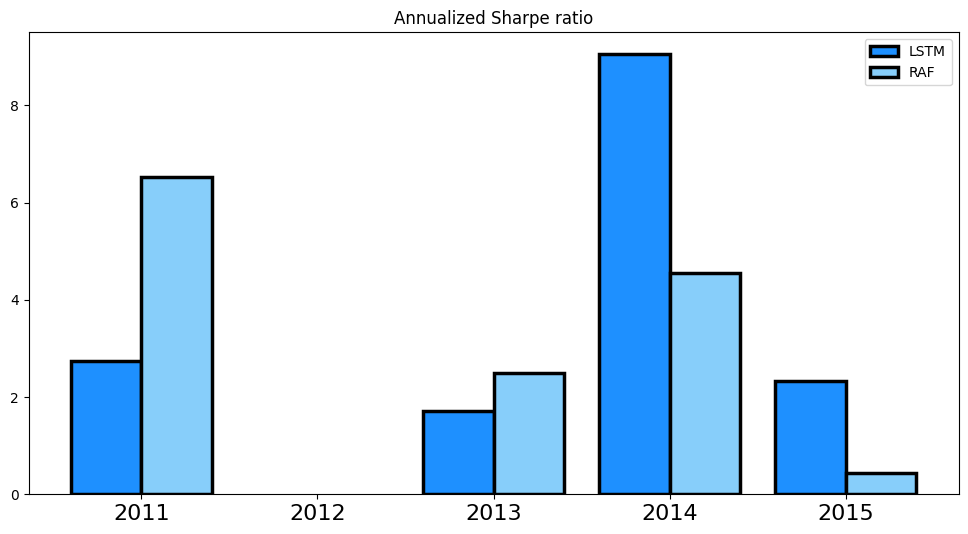

In [204]:
# 그림 사이즈, 바 굵기 조정
fig, ax = plt.subplots(figsize=(12,6))
bar_width = 0.4

index = np.arange(5)
p_lstm_0=plt.bar(index, df_sharpe_split[0]['Sharpe ratio']* np.sqrt(252), bar_width, color='dodgerblue', edgecolor = 'black', linewidth = 2.5,label='LSTM')
p_rf_0=plt.bar(index+ bar_width, df_rf_sharpe_split[0]['Sharpe ratio']* np.sqrt(252), bar_width, color='lightskyblue', edgecolor = 'black', linewidth = 2.5, label='RAF')
plt.title('Annualized Sharpe ratio')
plt.xticks(np.arange(0.2, 4 + bar_width, 1), df_sharpe_split[0]['Year'],fontsize=16)
plt.legend()
plt.show()

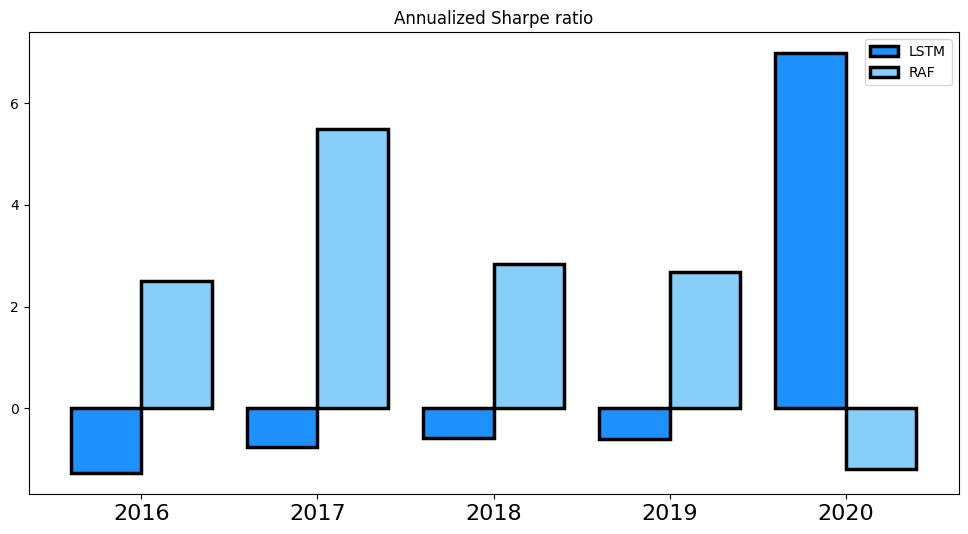

In [205]:
# 그림 사이즈, 바 굵기 조정
fig, ax = plt.subplots(figsize=(12,6))
bar_width = 0.4

index = np.arange(5)
p_lstm_0=plt.bar(index, df_sharpe_split[1]['Sharpe ratio']* np.sqrt(252), bar_width, color='dodgerblue', edgecolor = 'black', linewidth = 2.5,label='LSTM')
p_rf_0=plt.bar(index+ bar_width, df_rf_sharpe_split[1]['Sharpe ratio']* np.sqrt(252), bar_width, color='lightskyblue', edgecolor = 'black', linewidth = 2.5,label='RAF')
plt.title('Annualized Sharpe ratio')
plt.xticks(np.arange(0.2, 4 + bar_width, 1), df_sharpe_split[1]['Year'],fontsize=16)
plt.legend()
plt.show()

## average accuracy

In [215]:
def count_accu(K,df):
    count = 0
    for i in range(K):
        if df.iloc[i,1] == df.iloc[i,0]:
            count+=1
    for i in range(K):
        if df.iloc[-(i+1),1]== df.iloc[-(i+1),0]:
            count+=1
    return count

In [222]:
data=LSTM
import numpy as np
import datetime
import matplotlib.pyplot as plt

def ave_acc(data):
  data = data.sort_values(['Date','y_prob'],ascending = True)
  data=data.reset_index(drop=True)
  date_list = list(data.Date.unique())

  acc = {}
  for date in date_list:
    data_date = data[data.Date == date]
    data_date = data_date.reset_index(drop = True)
    accu_item = count_accu(4,data_date)
    accuracy_date = accu_item/(2*4)
    acc.update({date: accuracy_date})
    acc_date=pd.DataFrame(acc, index=[0]).T
  acc_date=acc_date.reset_index()
  acc_date.rename(columns={'index':'Date',0:'Accuracy'}, inplace=True)
  acc_date['Date']=pd.to_datetime(acc_date['Date'])
  acc_date['Year'] = acc_date['Date'].dt.strftime('%Y')
  acc_date.set_index('Date',inplace = True)
  acc_date_lstm=acc_date.groupby(['Year'], as_index=False).mean()
  
  acc_date_lstm_split = np.array_split(acc_date_lstm, 2)
  plt.figure(figsize=(10, 6))			
  plt.bar(acc_date_lstm_split[0]['Year'], acc_date_lstm_split[0]['Accuracy'], width=0.6, color='dodgerblue', edgecolor = 'black', linewidth = 2.5)

  acc_date_lstm_split = np.array_split(acc_date_lstm, 2)
  plt.figure(figsize=(10, 6))			
  plt.bar(acc_date_lstm_split[1]['Year'], acc_date_lstm_split[1]['Accuracy'], width=0.6, color='dodgerblue', edgecolor = 'black', linewidth = 2.5)
  
  return acc_date_lstm_split

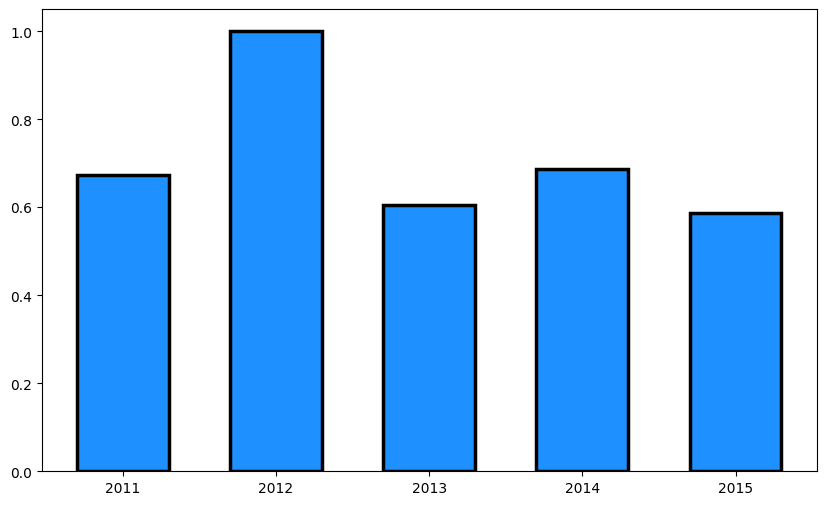

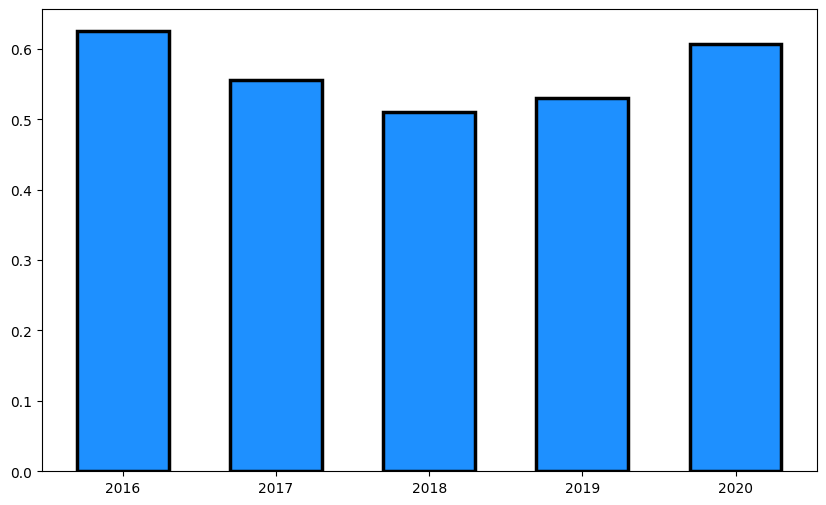

In [224]:
acc_date_lstm_split=ave_acc(LSTM)

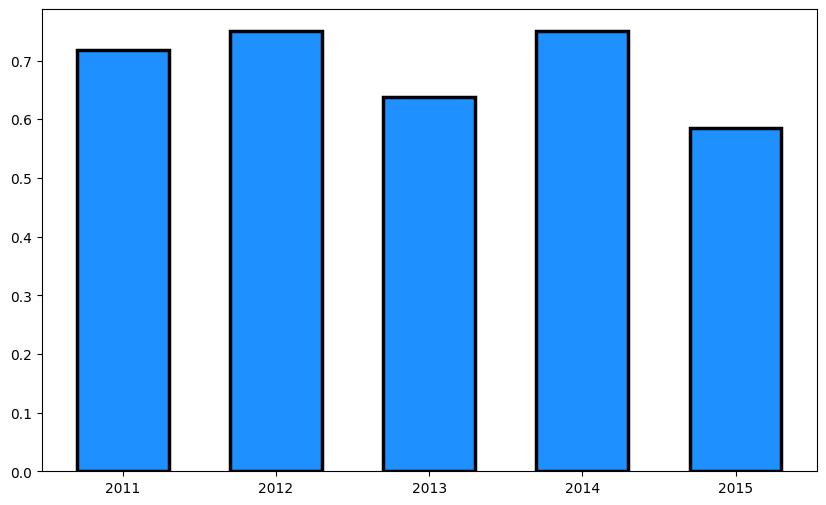

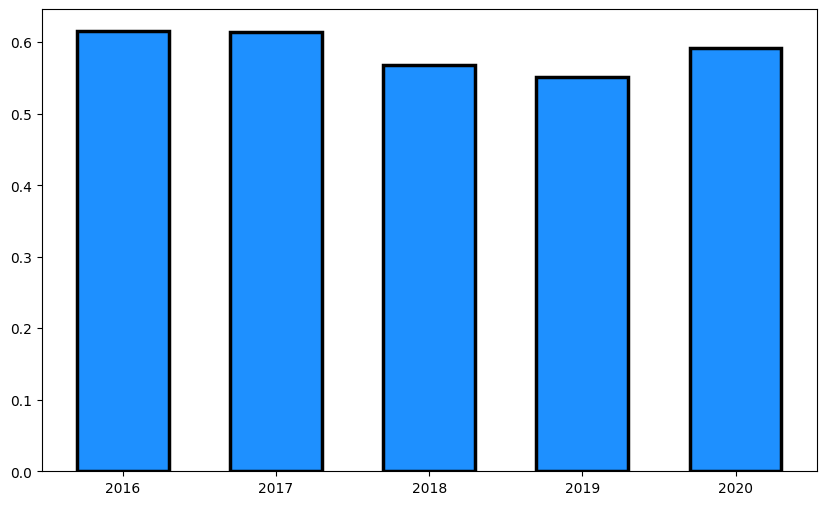

In [223]:
rf_split=ave_acc(RF)

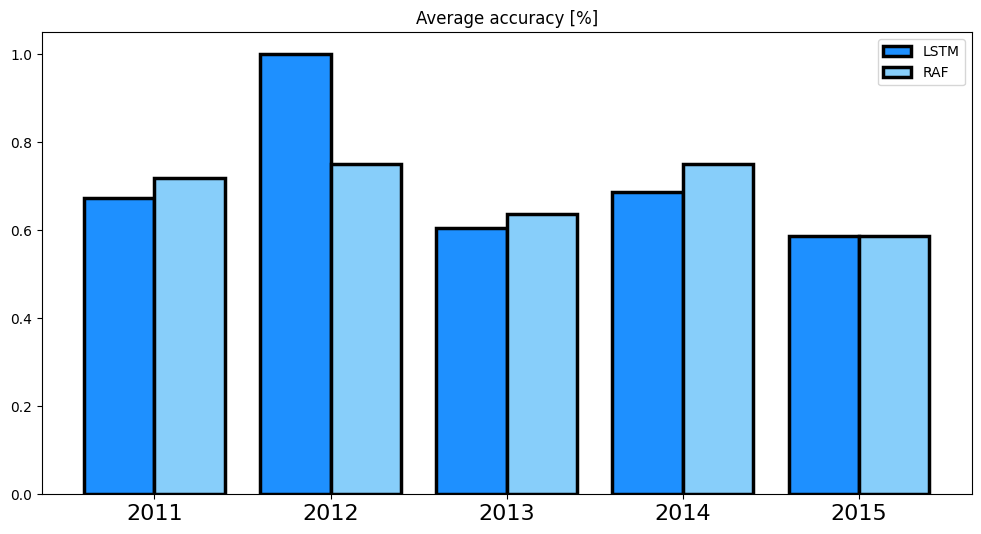

In [227]:
# 그림 사이즈, 바 굵기 조정
fig, ax = plt.subplots(figsize=(12,6))
bar_width = 0.4

index = np.arange(5)
a_lstm_0=plt.bar(index, acc_date_lstm_split[0]['Accuracy'], bar_width, color='dodgerblue', edgecolor = 'black', linewidth = 2.5, label='LSTM')
a_rf_0=plt.bar(index+ bar_width, rf_split[0]['Accuracy'], bar_width, color='lightskyblue', edgecolor = 'black', linewidth = 2.5, label='RAF')
plt.title('Average accuracy [%]')
plt.xticks(np.arange(0.2, 4 + bar_width, 1), rf_split[0]['Year'],fontsize=16)
#plt.yticks([0.50, 0.55, 0.60])
#plt.ylim([0.50, 0.65]) 
plt.legend()
plt.show()

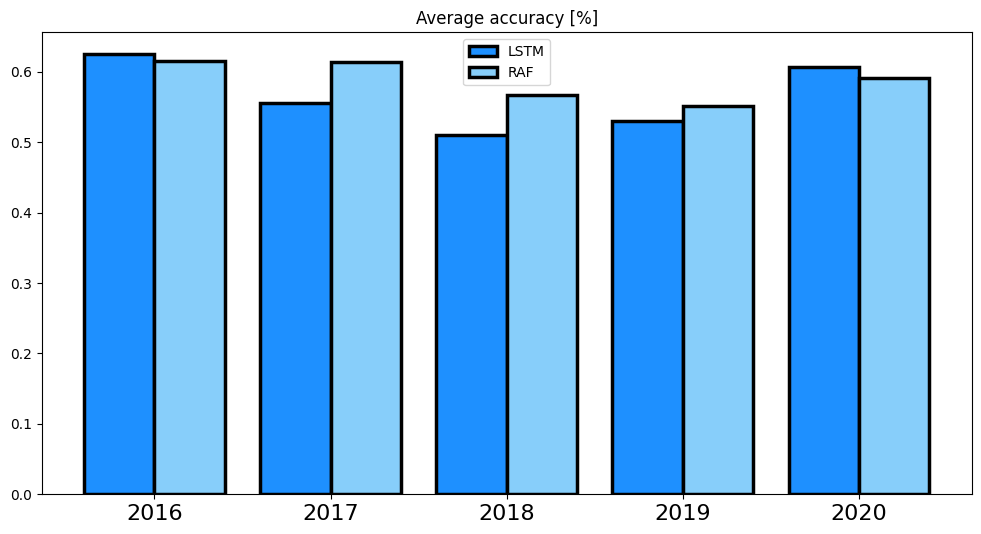

In [228]:
# 그림 사이즈, 바 굵기 조정
fig, ax = plt.subplots(figsize=(12,6))
bar_width = 0.4

index = np.arange(5)
a_lstm_0=plt.bar(index, acc_date_lstm_split[1]['Accuracy'], bar_width, color='dodgerblue', edgecolor = 'black', linewidth = 2.5, label='LSTM')
a_rf_0=plt.bar(index+ bar_width, rf_split[1]['Accuracy'], bar_width, color='lightskyblue', edgecolor = 'black', linewidth = 2.5, label='RAF')
plt.title('Average accuracy [%]')
plt.xticks(np.arange(0.2, 4 + bar_width, 1), rf_split[1]['Year'],fontsize=16)
#plt.yticks([0.50, 0.55, 0.60])
#plt.ylim([0.50, 0.65]) 
plt.legend()
plt.show()

In [3]:
from tqdm import tqdm
LSTM=LSTM.sort_values(['Date','y_prob'],ascending = True)
fulldata= pd.read_csv('data/Bond_return_file0712.csv',index_col=0,low_memory=False)
date_list = list(LSTM.Date.unique())
ls=pd.DataFrame()
for date in tqdm(date_list[:-1]):
  data_date = LSTM[LSTM.Date == date]
  short_part = data_date.iloc[:4]
  long_part = data_date.iloc[-4:]
  ls=pd.concat([ls,long_part, short_part])

100%|██████████| 624/624 [00:31<00:00, 19.86it/s]


In [4]:
fulldata.rename(columns={'종목코드':'bondcode','기준일자':'Date','적용신용등급':"credit_rate"}, inplace=True)
c=fulldata[['bondcode','Date','credit_rate']]
Merge_credit=pd.merge(ls,c,on=['bondcode','Date'],how='left')

In [7]:
ls_credit=Merge_credit.groupby(["Date","credit_rate"]).agg({"credit_rate":"count"})
ls_credit.rename(columns={'credit_rate':'Count_ls'}, inplace=True)
ls_credit['Count_ls_pct']=ls_credit['Count_ls']/22

In [8]:
raw_credit=c.groupby(["Date","credit_rate"]).agg({"credit_rate":"count"})
raw_credit.rename(columns={'credit_rate':'Count_raw'}, inplace=True)
raw_credit['Count_raw_pct']=raw_credit['Count_raw']/1400

In [9]:
raw_ls=pd.merge(ls_credit, raw_credit, on=['Date','credit_rate'],how='right')
raw_ls=raw_ls.fillna(0)
raw_ls['minus']=raw_ls['Count_ls_pct']-raw_ls['Count_raw_pct']
raw_ls=raw_ls.reset_index()
raw_ls['Date']=pd.to_datetime(raw_ls['Date'])
raw_ls['Year'] = raw_ls['Date'].dt.strftime('%Y')

In [10]:
import numpy as np
ls=[]
l=[]
credit_rate_list = list(raw_ls.credit_rate.unique())
for c in credit_rate_list:
    A=raw_ls[raw_ls['credit_rate']== c ]
    A=A.groupby(["Year","credit_rate"]).agg({"minus":"mean"})
    A=A.reset_index().iloc[3:,:]
    ls.append(A)
    l.append(c)

In [40]:
t=raw_ls[raw_ls['credit_rate']== 'A+' ].groupby(["Year","credit_rate"]).agg({"minus":"mean"})
t.reset_index().iloc[3:,:]

,Year,credit_rate,minus
3,2013,A+,-0.141439
4,2014,A+,-0.120997
5,2015,A+,-0.119551
6,2016,A+,-0.114644
7,2017,A+,-0.111712
8,2018,A+,-0.109628
9,2019,A+,-0.112913
10,2020,A+,-0.124464


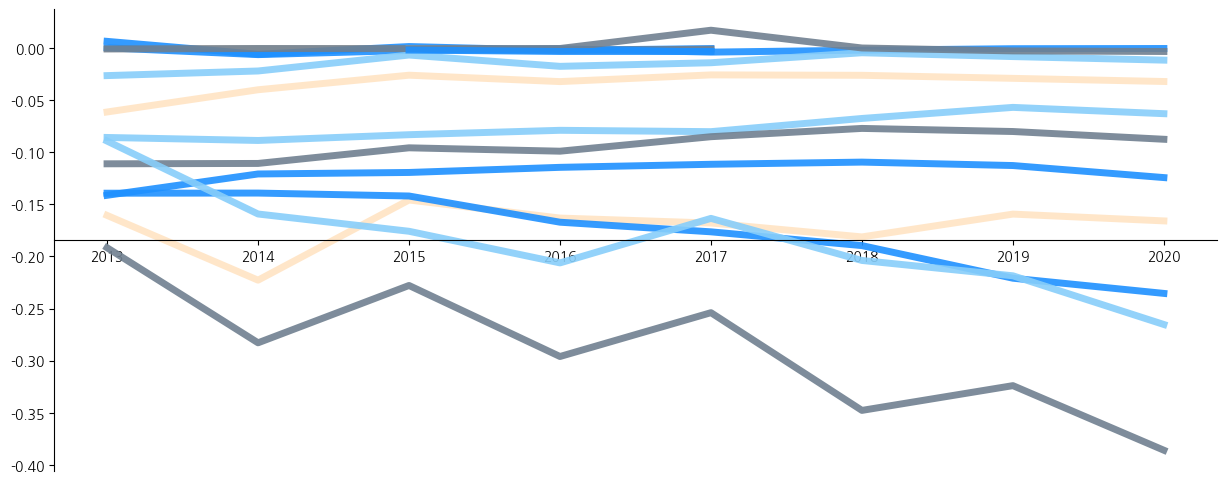

In [18]:
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

# 그림 사이즈, 바 굵기 조정
fig, ax = plt.subplots(figsize=(15,6)) 
# plt.ylim(-000.1, 0.1)
# plt.xlim(0,18)
# plt.yticks([-0.01,-0.005,0.0,0.005,0.01])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom') 
ax.yaxis.set_ticks_position('left')
ax.spines['bottom'].set_position('center')

colors=['dodgerblue','lightskyblue','slategray','bisque',
        'dodgerblue','lightskyblue','slategray','bisque',
        'dodgerblue','lightskyblue','slategray','bisque',
        'dodgerblue','lightskyblue','slategray','bisque',
        'dodgerblue','lightskyblue','slategray']

for df,c in zip(ls,colors):
    ax.plot(df['Year'], df['minus'], color=c, linewidth = 5,alpha = 0.9)

arrowprops = dict(color='black',arrowstyle="-")
for a in l:
    ax.annotate(a, xy=(17, 0.022541),xytext=(17.5,0.022541+0.005),arrowprops=arrowprops)

plt.rc('font', family='NanumGothicOTF')
plt.rc("axes", unicode_minus = False)
plt.show()

In [19]:
from tqdm import tqdm
LSTM=LSTM.sort_values(['Date','y_prob'],ascending = True)
fulldata= pd.read_csv('data/Bond_return_file0712.csv',index_col=0,low_memory=False)
date_list = list(LSTM.Date.unique())

long=pd.DataFrame()
short=pd.DataFrame()
for date in tqdm(date_list[:-1]):
  data_date = LSTM[LSTM.Date == date]
  short_part = data_date.iloc[:4]
  long_part = data_date.iloc[-4:]
  short=pd.concat([short, short_part])
  long=pd.concat([long, long_part])

100%|██████████| 624/624 [00:32<00:00, 19.17it/s]


In [22]:
fulldata.rename(columns={'종목코드':'bondcode','기준일자':'Date','적용신용등급':"credit_rate"}, inplace=True)
c=fulldata[['bondcode','Date','credit_rate']]

Long=pd.merge(long,c,on=['bondcode','Date'],how='left')
Short=pd.merge(short,c,on=['bondcode','Date'],how='left')

In [27]:
short_sector=Short.groupby(["Date","credit_rate"]).agg({"credit_rate":"count"})
short_sector.rename(columns={'credit_rate':'Count_short'}, inplace=True)
short_sector['Count_short_pct']=short_sector['Count_short']/4

long_sector=Long.groupby(["Date","credit_rate"]).agg({"credit_rate":"count"})
long_sector.rename(columns={'credit_rate':'Count_long'}, inplace=True)
long_sector['Count_long_pct']=long_sector['Count_long']/4

raw_sector= c.groupby(["Date","credit_rate"]).agg({"credit_rate":"count"})
raw_sector.rename(columns={'credit_rate':'Count_raw'}, inplace=True)
raw_sector['Count_raw_pct']=raw_sector['Count_raw']/1400

raw_short=pd.merge(short_sector, raw_sector, on=['Date','credit_rate'],how='right')
raw_short=raw_short.fillna(0)
raw_short['minus']=raw_short['Count_short_pct']-raw_short['Count_raw_pct']
raw_short=raw_short.reset_index()
raw_short['Date']=pd.to_datetime(raw_short['Date'])
raw_short['Year'] = raw_short['Date'].dt.strftime('%Y')

raw_long=pd.merge(long_sector, raw_sector, on=['Date','credit_rate'],how='right')
raw_long=raw_long.fillna(0)
raw_long['minus']=raw_long['Count_long_pct']-raw_long['Count_raw_pct']
raw_long=raw_long.reset_index()
raw_long['Date']=pd.to_datetime(raw_long['Date'])
raw_long['Year'] = raw_long['Date'].dt.strftime('%Y')

In [29]:
import numpy as np
long_s=[]
long_l=[]

short_s=[]
short_l=[]

credit_rate_list = list(raw_sector.reset_index().credit_rate.unique())

for c in credit_rate_list:
    A_long=raw_long[raw_ls['credit_rate']== c ]
    A_short=raw_short[raw_ls['credit_rate']== c ]
    
    LONG=A_long.groupby(["Year","credit_rate"]).agg({"minus":"mean"})
    LONG=LONG.reset_index()
    
    SHORT=A_short.groupby(["Year","credit_rate"]).agg({"minus":"mean"})
    SHORT=SHORT.reset_index()
    
    long_s.append(LONG)
    long_l.append(c)
    
    short_s.append(SHORT)
    short_l.append(c)

In [35]:
import matplotlib.pyplot as plt


longdf=long_s[0]
shortdf=short_s[0]
t= long_l[0]

def mkplot(longdf,shortdf,t):
    fig, ax = plt.subplots(figsize=(10,6))
    plt.plot(shortdf['Year'], shortdf['minus'], color='dodgerblue', linewidth = 5)
    plt.plot(longdf['Year'], longdf['minus'], color='lightskyblue', linewidth = 5)
    plt.title(t)
    plt.grid(True)
    #plt.yticks([-0.1,0.0,0.1,0.2,0.3])
    #plt.xticks(['2007', '2012', '2017', '2022'])
    #plt.xlim(['2005', '2022']) 
    plt.legend(('Top-k','Flop-k'))
    plt.rc("axes", unicode_minus = False)
    plt.show()

In [ ]:
for a,b,c in zip(long_s,short_s,long_l):
    mkplot(a,b,c)

## Time-series Characteristics

In [37]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from datetime import datetime, timedelta

In [157]:
def get(m):
    train_base_root= 'data/train_test/n_Train/'
    test_base_root= 'data/train_test/n_Test/'

    train_data = np.load(train_base_root+str(m)+'/XY.npz',allow_pickle=True)
    trainX = train_data['x']
    trainY= train_data['y']
    trainLY= train_data['l']

    test_data = np.load(test_base_root+str(m)+'/XY.npz',allow_pickle=True)
    testX =test_data['x']
    testY=test_data['y']
    testLY=test_data['l']

    Train_dates_bondcode=np.load(train_base_root+str(m)+'/target_date_bondcode.npz',allow_pickle=True)
    train_target_date = Train_dates_bondcode['targetdate']
    train_target_bondcode = Train_dates_bondcode['bondcode']

    Test_dates_bondcode=np.load(test_base_root+str(m)+'/target_date_bondcode.npz',allow_pickle=True)
    test_target_date = Test_dates_bondcode['targetdate']
    test_target_bondcode = Test_dates_bondcode['bondcode']
    
    return trainX,trainY,trainLY,testX,testY,testLY,train_target_date,train_target_bondcode,test_target_date,test_target_bondcode

L=[]
for m in tqdm(range(5)):
    m=0
    trainX,trainY,trainLY,testX,testY,testLY,train_target_date,train_target_bondcode,test_target_date,test_target_bondcode = get(m)
    trainx = np.concatenate(trainX)
    bondcodes=np.concatenate([[j[0]]*i.shape[0] for i,j in zip(train_target_date,train_target_bondcode)]).ravel()
    X=pd.DataFrame(trainx)
    B=pd.Series(bondcodes,name='bondcodes')
    full=pd.concat([X,B],axis=1)
    L.append(full)


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


In [158]:
FULL=pd.concat(L)

In [44]:
ret=pd.read_csv('data/label_returns.csv',index_col=0)

In [81]:
La=[]
ls=Long[Long.y_pred == Long.y_true]
for d in Long.Date.unique():
    A=Long[Long.Date == d].sort_values('return',ascending=True)
    La.append(A.iloc[:10,:])
    
Sa=[]
ls=Short[Short.y_pred == Short.y_true]
for d in Short.Date.unique():
    A=ls[Short.Date == d].sort_values('return',ascending=True)
    Sa.append(A.iloc[:10,:])

In [85]:
r=[]
for d in Long.Date.unique():
    A=ret[ret.Date == d].sort_values('Return',ascending=True)
    r.append(A.iloc[:10,:])

In [86]:
lstm_long_ret=pd.concat(La)
lstm_short_ret=pd.concat(Sa)
#full_ret=pd.concat(r)

In [159]:
LONG=FULL[FULL.iloc[:,-1].isin(lstm_long_ret.bondcode)]
SHORT=FULL[FULL.iloc[:,-1].isin(lstm_short_ret.bondcode)]


In [167]:
GL=np.mean(LONG.groupby('bondcodes').mean())
GS=np.mean(SHORT.groupby('bondcodes').mean())
GF=np.mean(FULL.groupby('bondcodes').mean())
data_top_flop_10=pd.concat([GL,GS,GF],join='inner',axis=1,names=['Long','Short','Full'])

In [102]:
# GL=lstm_long_ret.groupby(['Date']).mean()['return']
# GL.rename({'return':'long_ret'}, inplace=True)

# GS=lstm_short_ret.groupby(['Date']).mean()['return']
# GS.rename({'return':'short_ret'}, inplace=True)

# GF=full_ret.groupby(['Date']).mean()['Return']
# GF.rename({'Return':'full_ret'}, inplace=True)

# data_top_flop_10=pd.concat([GL,GS,GF],join='inner',axis=1)

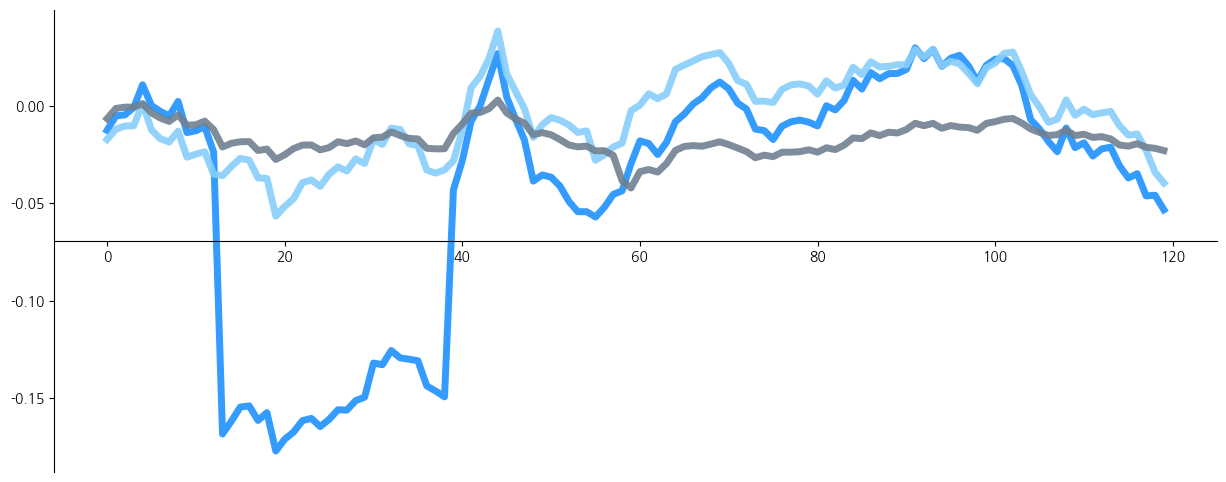

In [165]:
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

fig, ax = plt.subplots(figsize=(15,6)) 

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom') 
ax.yaxis.set_ticks_position('left')
ax.spines['bottom'].set_position('center')

i=[i for i in range(len(data_top_flop_10))]
ax.plot(i, data_top_flop_10.iloc[:,0], color='dodgerblue', linewidth = 5,alpha = 0.9)
ax.plot(i, data_top_flop_10.iloc[:,1], color='lightskyblue', linewidth = 5,alpha = 0.9)
ax.plot(i, data_top_flop_10.iloc[:,2], color='slategray', linewidth = 5,alpha = 0.9)

arrowprops = dict(color='black',arrowstyle="-")

# ax.annotate(a, xy=(17, 0.022541),xytext=(17.5,0.022541+0.005),arrowprops=arrowprops)

plt.rc('font', family='NanumGothicOTF')
plt.rc("axes", unicode_minus = False)
plt.show()